##### Data Wrangling

In [ ]:
#Regression: Can you predict the rating of the drug based on the review?

In [2]:
#Import the necessary libraries

import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import randint

import nltk
import html
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from scipy.stats import spearmanr, pearsonr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats
from sklearn.metrics import f1_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMModel, LGBMClassifier, plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
#Load the train and test datas

path='C:\\Users\\kurt_\\Dropbox\\code\\ulku\\Capstone2\\'
test=pd.read_csv(path+'data\\drugsComTest_raw.csv')
train=pd.read_csv(path+'data\\drugsComTrain_raw.csv')
print(train.head())

   uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37  


In [4]:
print(test.shape)
print(train.shape)

(53766, 7)
(161297, 7)


In [5]:
#Merge the test and train data for the next steps

merged = [train, test]
df = pd.concat(merged)

print (df.shape)
df.head()

(215063, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 13.1+ MB


In [7]:
#Check for column names

df.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

In [8]:
#Check for data types of columns

df.dtypes

uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

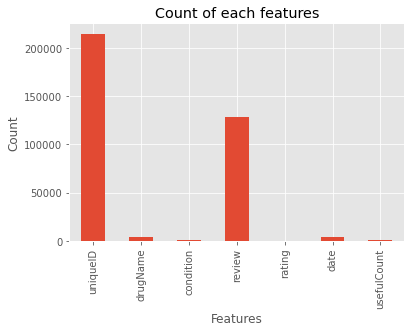

In [10]:
df.nunique().plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Count')
plt.title('Count of each features')
plt.style.use('ggplot')
plt.show()

In [11]:
#Check for NULL values

nan=pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns = ['NULL values'])
print(nan)

#Check percentage for NULL values

percentage = 100 * nan/len(df['condition'])
print(percentage)

             NULL values
condition           1194
usefulCount            0
date                   0
rating                 0
review                 0
drugName               0
uniqueID               0
             NULL values
condition       0.555186
usefulCount     0.000000
date            0.000000
rating          0.000000
review          0.000000
drugName        0.000000
uniqueID        0.000000


In [12]:
#Null values is lower than 1% so we delete them

df.dropna(inplace=True)
print(df.shape)

(213869, 7)


In [13]:
#Check for duplicate values

duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,uniqueID,drugName,condition,review,rating,date,usefulCount


In [14]:
#Check for value counts

print(df.rating.value_counts())
print(df.usefulCount.value_counts())
print(df.condition.value_counts())
print(df.drugName.value_counts())
print(df.review.value_counts())

10    67682
9     36499
1     28769
8     24909
7     12470
5     10650
2      9203
3      8662
6      8403
4      6622
Name: rating, dtype: int64
2      8438
3      8422
0      8266
4      8214
1      8125
       ... 
372       1
408       1
337       1
476       1
288       1
Name: usefulCount, Length: 397, dtype: int64
Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Diagnostic Bronchograms                             1
Thyroid Suppression Test                            1
Sepsis                                              1
100</span> users found this comment helpful.        1
40</span> users found this comment helpful.         1
Name: condition, Length: 916, dtype: int64
Levonorgestrel                       48

In [15]:
print(df.agg([min, max]).T)
print(df.describe())

                                                           min  \
uniqueID                                                     0   
drugName                             A + D Cracked Skin Relief   
condition           0</span> users found this comment helpful.   
review       "\r\n\r\n please tell the ones who is sufferin...   
rating                                                       1   
date                                                  1-Apr-08   
usefulCount                                                  0   

                                                           max  
uniqueID                                                232291  
drugName                                              pHisoHex  
condition                                          zen Shoulde  
review       "❤️❤️❤️ Cialis for US!!    I wish I had my hus...  
rating                                                      10  
date                                                  9-Sep-17  
usefulCount     